In [1]:
import multiprocessing as mp
import os, sys
import time
from multiprocessing.context import Process

import cv2

from text_renderer.config import get_cfg, GeneratorCfg
from text_renderer.dataset import ImgDataset
from text_renderer.render import Render
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../')

from playdict_ocr.datasets import RecognizationDataset

In [2]:
from text_renderer.corpus import Corpus
from playdict_ocr.word_generator import WordGenerator

class GameOcrCorpus(Corpus):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.wg = WordGenerator()

    def get_text(self):
        return self.wg.generate_word()

In [3]:
from text_renderer.effect import *
from text_renderer.corpus import *
from text_renderer.config import (
    RenderCfg,
    NormPerspectiveTransformCfg,
    GeneratorCfg,
    SimpleTextColorCfg,
)

In [4]:
import pathlib

render_cfg = RenderCfg(
    bg_dir=pathlib.Path("bg"),
    height=32,
    perspective_transform=NormPerspectiveTransformCfg(20, 20, 1.5),
    corpus=GameOcrCorpus(
        RandCorpusCfg(
            font_dir=pathlib.Path("font"),
            font_size=(64, 120),
        ),
    ),
    gray=True,
    #layout_effects=Padding(p=1, w_ratio=(0.0, 0.5), h_ratio=(0.0, 0.5), center=False),
)

def new_renderer():
    return Render(render_cfg)

In [5]:
render = new_renderer()

In [6]:
target_width = 144

def generate_img():
    img, label = render()

    # random flip
    if np.random.uniform(0, 1) > 0.5:
        img = 255 - img

    img = cv2.resize(img, (target_width, 32))

    return img, label

In [7]:
def show_img(img, label=None):
    plt.imshow(img)
    plt.ylim(32, 0)
    if label is not None:
        plt.title(label)

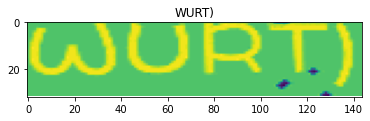

In [8]:
show_img(*generate_img())

In [9]:
from tqdm import tqdm, trange
import multiprocessing.dummy as mp
import gc

cnt = 2000000

def loop_body(i):
    img, label = generate_img()
    data[i] = img
    tgt[i] = label

for i in range(3):
    data, tgt = np.zeros([cnt, 32, 144], dtype='uint8'), [None] * cnt

    with mp.Pool(8) as p:
        with tqdm(total=cnt) as pbar:
            for _ in p.imap_unordered(loop_body, range(cnt)):
                pbar.update()

    dataset = RecognizationDataset(data, tgt)
    dataset.to_pickle(f'synth_{i}.pkl')

  0%|          | 2181/2000000 [00:19<4:29:07, 123.72it/s]